#  Автоэнкодеры

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://www.eecs.qmul.ac.uk/~sgg/_ECS795P_/papers/WK07-8_PyTorch_Tutorial2.html
* https://www.youtube.com/watch?v=zp8clK9yCro
* https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
* https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a
* https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py

## Задачи для совместного разбора

1\. Обсудите основные шаги в обучении автокодировщиков.

### Основные шаги в обучении автокодировщиков

1. **Подготовка данных**  
   Входные данные приводятся к удобному числовому формату и нормализуются.  
   В задаче с изображениями (например, MNIST) это означает перевод пикселей в диапазон \([0, 1]\).  
   Автокодировщики обучаются без явных целевых меток: в качестве целевого объекта используется сам вход.

2. **Построение архитектуры автокодировщика**  
   Модель состоит из двух частей:
   - **Кодировщик (encoder)**, который отображает входные данные \(x\) в скрытое представление \(z\) меньшей размерности.
   - **Декодировщик (decoder)**, который восстанавливает вход \(\hat{x}\) из латентного вектора \(z\).  
   Ключевая идея — наличие “узкого места” (bottleneck), заставляющего модель сжимать информацию.

3. **Выбор функции потерь**  
   Функция потерь измеряет ошибку реконструкции между исходным объектом \(x\) и восстановленным \(\hat{x}\).  
   На практике часто используются:
   - `MSELoss` — для вещественных данных и задач реконструкции,
   - `BCELoss` — когда выход интерпретируется как вероятность (например, пиксели в \([0,1]\)).  

4. **Прямой проход (forward pass)**  
   Входные данные проходят через кодировщик и декодировщик:
   \[
   x \rightarrow z = f_\theta(x) \rightarrow \hat{x} = g_\phi(z)
   \]
   На этом этапе вычисляется реконструкция входа.

5. **Обратное распространение ошибки (backpropagation)**  
   На основе функции потерь вычисляются градиенты по параметрам модели.  
   Эти градиенты показывают, как нужно изменить веса кодировщика и декодировщика, чтобы уменьшить ошибку реконструкции.

6. **Обновление параметров модели**  
   С помощью оптимизатора (например, Adam или SGD) параметры модели обновляются в направлении уменьшения функции потерь.  
   Этот шаг повторяется для каждого батча данных.

7. **Оценка качества и повторение обучения**  
   Обучение проводится в течение нескольких эпох.  
   Качество модели оценивается по величине ошибки реконструкции на обучающей и тестовой выборках, а также визуально (сравнение исходных и восстановленных объектов).

В результате обучения автокодировщик учится извлекать компактное латентное представление данных, содержащее наиболее важную информацию, необходимую для восстановления исходного входа.


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Загрузите набор данных MNIST из пакета `torchvision` (данный набор уже разбит на обучающее и тестовое множество). 

Создайте и обучите модель автокодировщика, используя только полносвязные слои и функции активации. 

Кодировщик - это функция вида 
$z = f_\theta(x)$
,где $\theta$ - это параметры кодировщика.

Декодировщик - это функция вида 
$\hat{x} = g_\phi(z)$
,где $\phi$ - это параметры декодировщика.

В нашем случае оба компонента представляют собой нейронные сети. Скрытое представление, полученное после части-кодировщика, должно иметь размерность 2. Последним слоем части-декодеровщика сделайте сигмоиду. 

В качестве функции потерь используйте `MSELoss` между исходным и восстановленным изображением $MSE(x, \hat{x})$. 

Обратите внимание, что во время обучения метки классов не используются.


- [ ] Проверено на семинаре

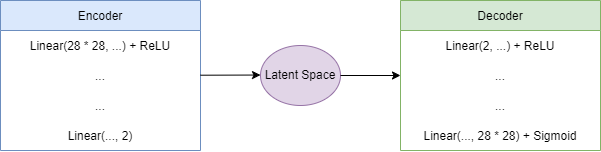

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [ ]:

BATCH_SIZE = 256
LATENT_DIM = 2
EPOCHS = 5
LR = 1e-3
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"


tfm = transforms.ToTensor()

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [01:57<00:00, 84.1kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 61.6kB/s]
100%|██████████| 1.65M/1.65M [00:12<00:00, 129kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7kB/s]


In [7]:

class FCAutoEncoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),              # (B, 1, 28, 28) -> (B, 784)
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim) # z
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),              # output in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z).view(-1, 1, 28, 28)
        return x_hat, z

model = FCAutoEncoder(latent_dim=LATENT_DIM).to(DEVICE)


In [8]:

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    for x, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion)
    te = eval_epoch(model, test_loader, criterion)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={tr:.4f} | test_loss={te:.4f}")


Epoch 1/5 | train_loss=0.0666 | test_loss=0.0378
Epoch 2/5 | train_loss=0.0315 | test_loss=0.0261
Epoch 3/5 | train_loss=0.0240 | test_loss=0.0217
Epoch 4/5 | train_loss=0.0205 | test_loss=0.0185
Epoch 5/5 | train_loss=0.0176 | test_loss=0.0162


<p class="task" id="2"></p>

2\. Получите один батч из тестового множества. Используя модель, обученную в предыдущем задании, получите скрытые представления для всех изображений из этого батча и визуализируйте на плоскости (они должны иметь размерность 2!). Раскрасьте точки в цвета, соответствующие меткам класса изображений (цифрам).

Возьмите одно изображение из тестового множества и пропустите его через обученный автокодировщик. Визуализируйте рядом (по горизонтали) два изображения: исходное и после восстановления автокодировщиком.


- [ ] Проверено на семинаре

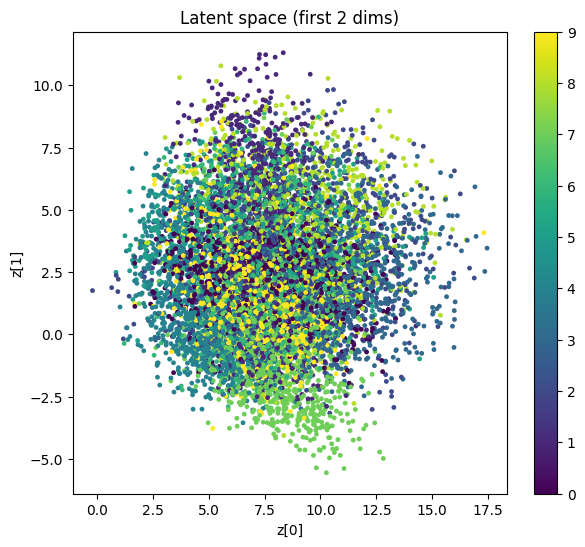

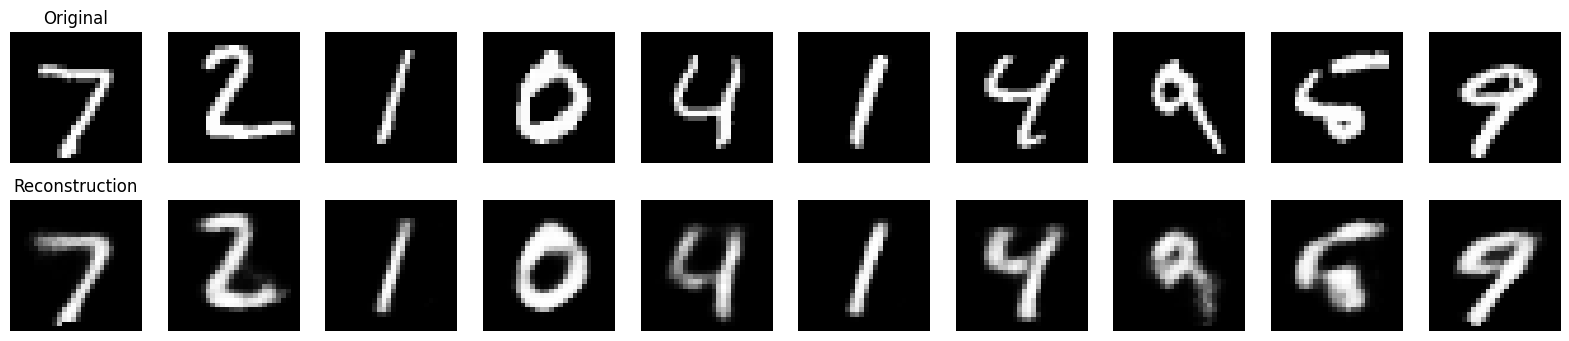

In [9]:
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_latents(model, loader, max_batches=None):
    model.eval()
    Z, Y = [], []
    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x = x.to(DEVICE, non_blocking=True)
        _, z = model(x)
        Z.append(z.cpu())
        Y.append(y)
    Z = torch.cat(Z, dim=0).numpy()
    Y = torch.cat(Y, dim=0).numpy()
    return Z, Y

# 1) Latents for test set
Z_test, y_test = collect_latents(model, test_loader)

# 2) If latent_dim >= 2: plot first two coordinates
if Z_test.shape[1] >= 2:
    plt.figure(figsize=(7, 6))
    sc = plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test, s=6)
    plt.colorbar(sc)
    plt.title("Latent space (first 2 dims)")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
else:
    print("LATENT_DIM < 2: cannot make 2D scatter. Set LATENT_DIM=2 for this plot.")

# 3) Show original vs reconstruction (first 10 images)
@torch.no_grad()
def show_reconstructions(model, loader, n=10):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(DEVICE)
    x_hat, _ = model(x)

    x = x.cpu()
    x_hat = x_hat.cpu()

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.imshow(x[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # recon
        plt.subplot(2, n, n+i+1)
        plt.imshow(x_hat[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")
    plt.show()

show_reconstructions(model, test_loader, n=10)


<p class="task" id="3"></p>

3\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения и пропускать его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

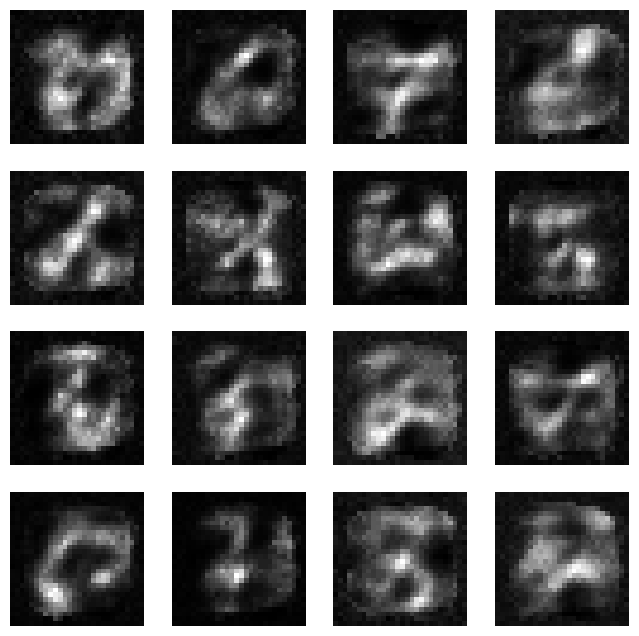

In [10]:
import math
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_from_noise(model, n_samples=16):
    model.eval()

    # 1) стандартный нормальный шум N(0, I)
    z = torch.randn(n_samples, LATENT_DIM, device=DEVICE)

    # 2) пропускаем через декодер
    x_gen = model.decoder(z)
    x_gen = x_gen.view(-1, 1, 28, 28).cpu()

    return x_gen


def show_generated_images(images, n_cols=4):
    n = images.size(0)
    n_rows = math.ceil(n / n_cols)

    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.axis("off")
    plt.show()


# Генерация и визуализация
generated_images = generate_from_noise(model, n_samples=16)
show_generated_images(generated_images, n_cols=4)


<p class="task" id="4"></p>

4\. Создайте и обучите модель условного автокодировщика, используя только полносвязные слои и функции активации. 

Отличие от предыдущего варианта заключается в том, что теперь функции кодировщика и декодировщика принимают на вход также метку класса Conditional:
$$z = f_\theta(x, c)$$
$$\hat{x} = g_\phi(z, c)$$

Таким образом, теперь во теперь время обучения метки классов используются. Задействуйте их следующим образом: представьте метки классов в виде one-hot кодировки и объедините с пикселями изображения (для этого адаптируйте размерность слоев). 

Скрытое представление, полученное после части-кодировщика, должно иметь размерность 2. Последним слоем части-декодеровщика сделайте сигмоиду. В качестве функции потерь используйте `MSELoss` между исходным и восстановленным изображением $MSE(x, \hat{x})$. 


- [ ] Проверено на семинаре

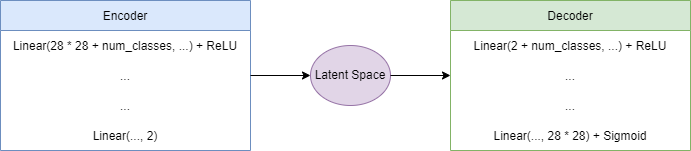

In [ ]:
COND_LATENT_DIM = 2
NUM_CLASSES = 10

# --------------------
# Conditional FC AutoEncoder
# z = f(x, c), x_hat = g(z, c)
# c -> one-hot, concat
# --------------------
class ConditionalFCAutoEncoder(nn.Module):
    def __init__(self, latent_dim=2, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder takes [x_flat (784), c_onehot (10)] => 794
        self.encoder = nn.Sequential(
            nn.Linear(784 + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder takes [z (2), c_onehot (10)] => 12
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid() 
        )

    def forward(self, x, y):
        # x: (B, 1, 28, 28), y: (B,)
        b = x.size(0)
        x_flat = x.view(b, -1)  # (B, 784)

        c = torch.nn.functional.one_hot(y, num_classes=self.num_classes).float()  # (B, 10)

        enc_in = torch.cat([x_flat, c], dim=1)               # (B, 794)
        z = self.encoder(enc_in)                             # (B, 2)

        dec_in = torch.cat([z, c], dim=1)                    # (B, 12)
        x_hat_flat = self.decoder(dec_in)                    # (B, 784)
        x_hat = x_hat_flat.view(b, 1, 28, 28)                # (B, 1, 28, 28)

        return x_hat, z


cond_model = ConditionalFCAutoEncoder(latent_dim=COND_LATENT_DIM, num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.MSELoss()  
optimizer = torch.optim.AdamW(cond_model.parameters(), lr=LR)


In [12]:

def train_one_epoch_cond(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        x_hat, _ = model(x, y)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_one_epoch_cond(model, loader, criterion):
    model.eval()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        x_hat, _ = model(x, y)
        loss = criterion(x_hat, x)

        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch_cond(cond_model, train_loader, optimizer, criterion)
    te = eval_one_epoch_cond(cond_model, test_loader, criterion)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={tr:.4f} | test_loss={te:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | train_loss=0.0676 | test_loss=0.0480
Epoch 2/5 | train_loss=0.0448 | test_loss=0.0421
Epoch 3/5 | train_loss=0.0409 | test_loss=0.0393
Epoch 4/5 | train_loss=0.0385 | test_loss=0.0377
Epoch 5/5 | train_loss=0.0370 | test_loss=0.0365


<p class="task" id="5"></p>

5\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения и one-hot представление цифры. Далее объединенный вектор пропускается его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

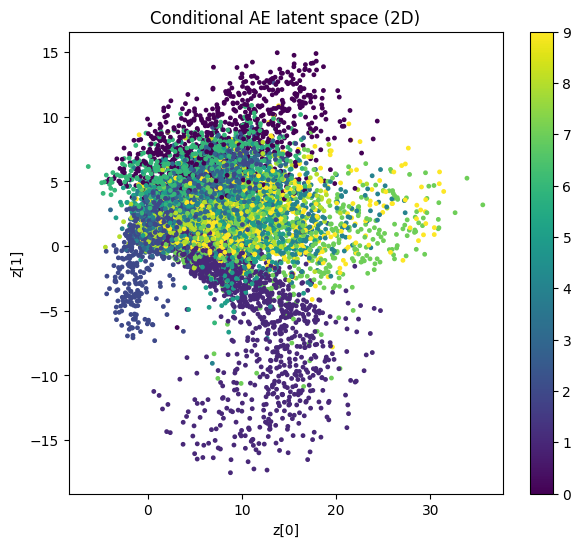

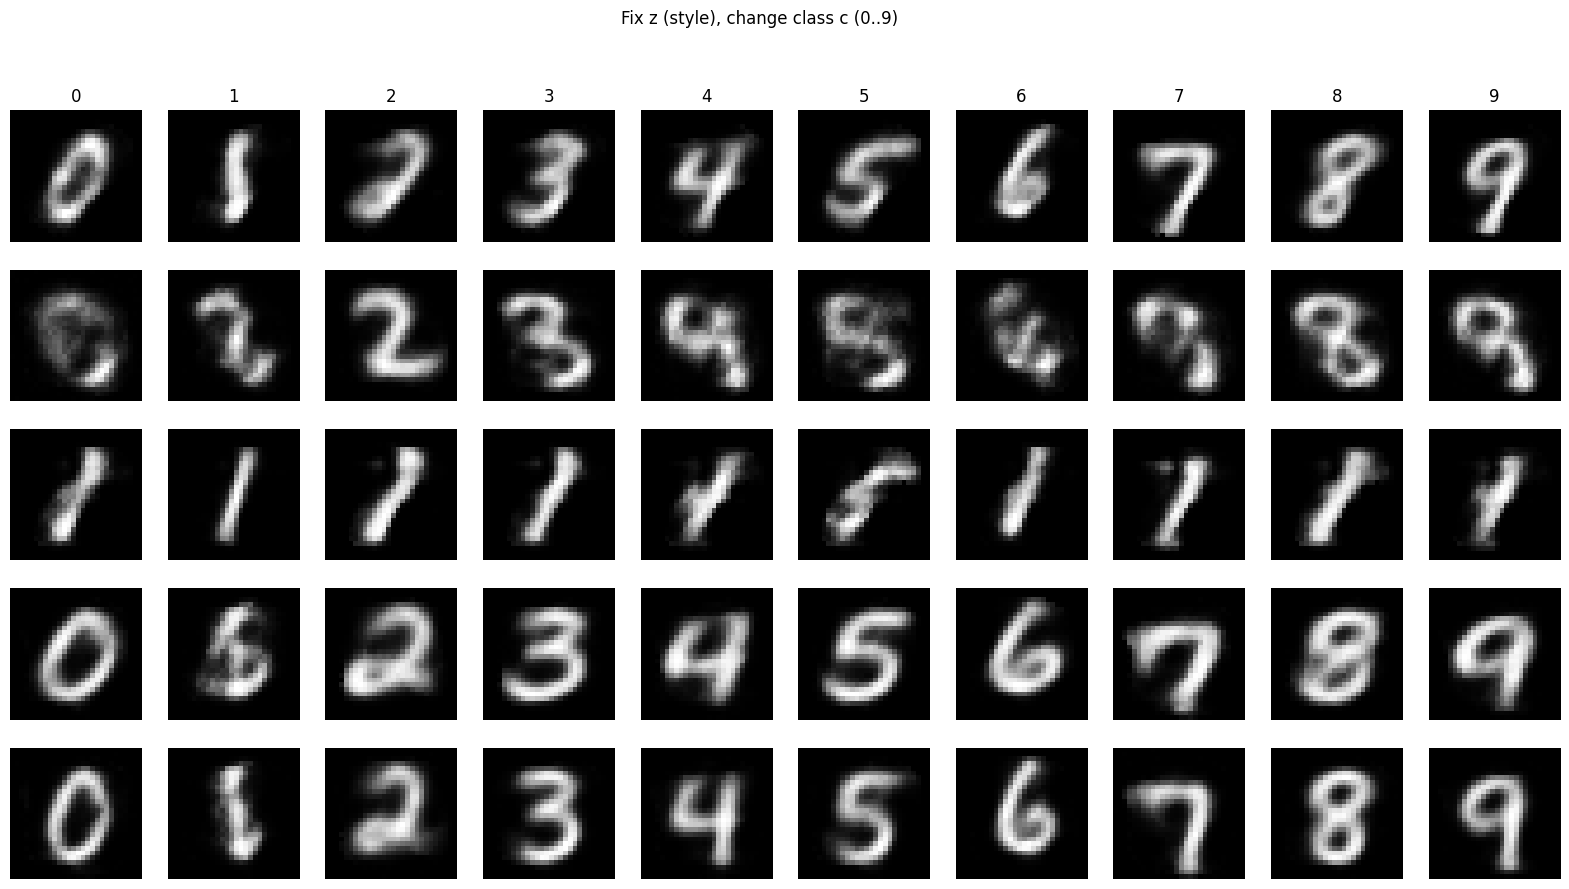

In [13]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def collect_latents_cond(model, loader, max_batches=None):
    model.eval()
    Z, Y = [], []
    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        _, z = model(x, y)
        Z.append(z.cpu())
        Y.append(y.cpu())

    Z = torch.cat(Z, dim=0).numpy()
    Y = torch.cat(Y, dim=0).numpy()
    return Z, Y


# 1) Latent space scatter (реально 2D, потому что latent_dim=2)
Z_test, y_test = collect_latents_cond(cond_model, test_loader)

plt.figure(figsize=(7, 6))
sc = plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test, s=6)
plt.colorbar(sc)
plt.title("Conditional AE latent space (2D)")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


# 2) Fixed x -> encode z, then decode with different class labels
@torch.no_grad()
def show_class_switching(model, loader, n_examples=5):
    model.eval()
    x, y = next(iter(loader))
    x = x[:n_examples].to(DEVICE)
    y = y[:n_examples].to(DEVICE)

    # one-hot for original labels to get z
    c_orig = torch.nn.functional.one_hot(y, num_classes=NUM_CLASSES).float()

    # encode z = f(x, c_orig)
    x_flat = x.view(n_examples, -1)
    z = model.encoder(torch.cat([x_flat, c_orig], dim=1))  # (n_examples, 2)

    # decode same z with different c = 0..9
    plt.figure(figsize=(2*NUM_CLASSES, 2*n_examples))
    for row in range(n_examples):
        for cls in range(NUM_CLASSES):
            y_cls = torch.tensor([cls], device=DEVICE).repeat(1)
            c_cls = torch.nn.functional.one_hot(y_cls, num_classes=NUM_CLASSES).float()  # (1,10)

            dec_in = torch.cat([z[row:row+1], c_cls], dim=1)  # (1, 12)
            x_hat = model.decoder(dec_in).view(1, 1, 28, 28).cpu()

            idx = row * NUM_CLASSES + cls + 1
            plt.subplot(n_examples, NUM_CLASSES, idx)
            plt.imshow(x_hat[0, 0], cmap="gray")
            plt.axis("off")
            if row == 0:
                plt.title(str(cls))
    plt.suptitle("Fix z (style), change class c (0..9)")
    plt.show()


show_class_switching(cond_model, test_loader, n_examples=5)


<p class="task" id="6"></p>

6\. Создайте и обучите модель вариационного автокодировщика, используя только полносвязные слои и функции активации. 

Кодировщик - это функция следующего вида:
$$q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi^2(x))$$

Здесь $\phi$ - параметры кодировщика, а $\mu_\phi(x)$ и $\sigma_\phi^2(x)$ - это обучаемые функции (в нашем случае - полносвязные слои).

Чтобы иметь возможность обучить такую модель, используется т.н. reparametrization trick: на основе функций $\mu$ и $ \sigma$ считаем значение:

$$z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Декодировщик пытается восстановить исходное изображение из полученного вектора:

$$p_\theta(x|z) = f(z; \theta)$$

В качестве функции потерь обычно используется следующая:
$$\mathcal{L}_{total} = \mathcal{L}_{recon} + D_{KL}$$
$$\mathcal{L}_{recon} = -\sum_{i=1}^D [x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i)]$$
$$D_{KL} = -\frac{1}{2} \sum_{j=1}^J (1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2)$$


для сравнения наших распределений
баланс между лосс

- [ ] Проверено на семинаре


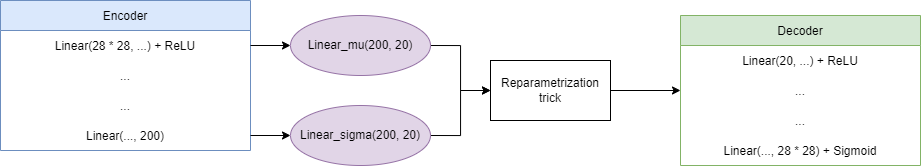

In [14]:
VAE_LATENT_DIM = 20
BATCH_SIZE = 256
EPOCHS = 10

# train_loader, test_loader должны уже быть (MNIST + ToTensor())


# --------------------
# Model: FC-VAE
# q(z|x) = N(mu(x), sigma(x)^2)
# --------------------
class FCVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: x -> hidden
        self.enc = nn.Sequential(
            nn.Flatten(),          # (B,1,28,28) -> (B,784)
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 200),
            nn.ReLU(),
        )
        # Two heads: mu and logvar
        self.mu_head = nn.Linear(200, latent_dim)
        self.logvar_head = nn.Linear(200, latent_dim)

        # Decoder: z -> x_hat
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),          # x_hat in [0,1] for BCE
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.mu_head(h)
        logvar = self.logvar_head(h)  # log(sigma^2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # sigma = exp(0.5 * logvar)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)   # epsilon ~ N(0, I)
        z = mu + std * eps
        return z

    def decode(self, z):
        x_hat = self.dec(z).view(-1, 1, 28, 28)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


vae = FCVAE(latent_dim=VAE_LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)


In [17]:

# --------------------
# Losses
# Recon: BCE (как в задании формула)
# KL: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
# --------------------
def vae_loss(x, x_hat, mu, logvar):
    # BCE по пикселям (усредним по батчу)
    recon = F.binary_cross_entropy(x_hat, x, reduction="sum") / x.size(0)

    # KL по латентным компонентам (усредним по батчу)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar)) / x.size(0)

    total = recon + kl
    return total, recon, kl

def train_one_epoch_vae(model, loader):
    model.train()
    total_sum, recon_sum, kl_sum = 0.0, 0.0, 0.0

    for x, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, mu, logvar = model(x)

        loss, recon, kl = vae_loss(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_sum += loss.item() * bs
        recon_sum += recon.item() * bs
        kl_sum += kl.item() * bs

    n = len(loader.dataset)
    return total_sum / n, recon_sum / n, kl_sum / n

@torch.no_grad()
def eval_one_epoch_vae(model, loader):
    model.eval()
    total_sum, recon_sum, kl_sum = 0.0, 0.0, 0.0

    for x, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar)

        bs = x.size(0)
        total_sum += loss.item() * bs
        recon_sum += recon.item() * bs
        kl_sum += kl.item() * bs

    n = len(loader.dataset)
    return total_sum / n, recon_sum / n, kl_sum / n


for epoch in range(1, EPOCHS + 1):
    tr_total, tr_rec, tr_kl = train_one_epoch_vae(vae, train_loader)
    te_total, te_rec, te_kl = eval_one_epoch_vae(vae, test_loader)
    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train: total={tr_total:.4f} recon={tr_rec:.4f} kl={tr_kl:.4f} | "
        f"test:  total={te_total:.4f} recon={te_rec:.4f} kl={te_kl:.4f}"
    )


Epoch 1/10 | train: total=211.4924 recon=207.4036 kl=4.0888 | test:  total=178.1589 recon=170.8801 kl=7.2788
Epoch 2/10 | train: total=157.1328 recon=146.1266 kl=11.0063 | test:  total=143.1222 recon=129.7543 kl=13.3680
Epoch 3/10 | train: total=137.2827 recon=123.2828 kl=13.9999 | test:  total=130.8400 recon=115.6315 kl=15.2084
Epoch 4/10 | train: total=127.9691 recon=112.5266 kl=15.4425 | test:  total=123.2707 recon=106.6154 kl=16.6553
Epoch 5/10 | train: total=121.8559 recon=105.1141 kl=16.7418 | test:  total=118.7137 recon=101.4859 kl=17.2278
Epoch 6/10 | train: total=118.0487 recon=100.6769 kl=17.3718 | test:  total=115.6367 recon=97.8654 kl=17.7713
Epoch 7/10 | train: total=115.4913 recon=97.6670 kl=17.8243 | test:  total=113.5767 recon=95.1781 kl=18.3986
Epoch 8/10 | train: total=113.6120 recon=95.4326 kl=18.1794 | test:  total=111.9864 recon=93.5504 kl=18.4360
Epoch 9/10 | train: total=112.1229 recon=93.6290 kl=18.4939 | test:  total=110.4103 recon=91.5288 kl=18.8815
Epoch 10/1

<p class="task" id="7"></p>

7\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения. Далее вектор пропускается его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре



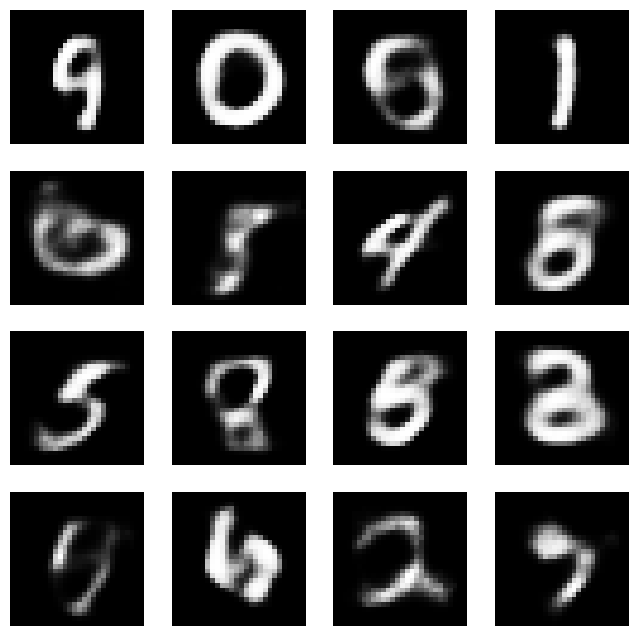

In [18]:
import math
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def vae_generate(model, n_samples=16):
    model.eval()
    z = torch.randn(n_samples, model.latent_dim, device=DEVICE)  # z ~ N(0, I)
    x_gen = model.decode(z).cpu()                                 # (B,1,28,28)
    return x_gen

def show_grid(images, n_cols=4):
    n = images.size(0)
    n_rows = math.ceil(n / n_cols)

    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.axis("off")
    plt.show()


generated = vae_generate(vae, n_samples=16)
show_grid(generated, n_cols=4)
